In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import os
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential

In [2]:
# Making sure tensorflow gpu doesn't waste vram
gpus=tf.config.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    print(len(gpus))
    tf.config.experimental.set_memory_growth(gpu,True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1


In [3]:
train_dir="..\\Data\\train"
os.listdir(train_dir)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [4]:
# Making the data pipeline for Input data.
# Making Generator
data=tf.keras.utils.image_dataset_from_directory(train_dir,batch_size=64,color_mode='grayscale',image_size=(48,48))
# Making Iterator
data_iterator=data.as_numpy_iterator();
batch=data_iterator.next();

print(data)

#X
print(batch[0].shape)
#y
print(batch[1].shape)

Found 28709 files belonging to 7 classes.
<BatchDataset element_spec=(TensorSpec(shape=(None, 48, 48, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
(64, 48, 48, 1)
(64,)


In [5]:
# Normalising the input
data=data.map(lambda x,y:(x/255,y))
scaled_data_iterator=data.as_numpy_iterator()
batch=scaled_data_iterator.next()

In [6]:
train_size=int(len(data)*0.75)
val_size=int(len(data))-train_size

train=data.take(train_size)
val=data.skip(train_size).take(val_size)

iterator=train.as_numpy_iterator()
batch=iterator.next()
print(batch[1].shape)

(64,)


In [10]:
# Defining the model
# model=Sequential([
#     Conv2D(filters=30,kernel_size=(3,3),strides=1,activation='relu',name='layer1',input_shape=(256,256,3)),
#     Conv2D(filters=20,kernel_size=(3,3),strides=1,activation='relu',name='layer2'),
#     Conv2D(filters=10,kernel_size=(3,3),strides=1,activation='relu',name='layer3'),
#     MaxPool2D(pool_size=(2,3)),
#     Dropout(0.25),

#     Conv2D(filters=30,kernel_size=(3,3),strides=1,activation='relu',name='layer4'),
#     Conv2D(filters=20,kernel_size=(3,3),strides=1,activation='relu',name='layer5'),
#     MaxPool2D(pool_size=(2,3)),
#     Dropout(0.05),

#     Conv2D(filters=20,kernel_size=(3,3),strides=1,activation='relu',name='layer6'),
#     Conv2D(filters=10,kernel_size=(3,3),strides=1,activation='relu',name='layer7'),
#     MaxPool2D(pool_size=(2,3)),
#     Dropout(0.05),

#     Dense(units=50,activation='relu',name='layer8'),
#     Flatten(),
#     Flatten(),
#     Dense(units=7,activation='softmax',name='layer9'),
# ])
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten,BatchNormalization
from keras import regularizers

model= tf.keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) 
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
    
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

# model = Sequential()
# model.add(Conv2D(10, (3, 3), activation='relu', input_shape=(120, 120, 1)))
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.3))
# model.add(Conv2D(10, (3, 3), activation='relu'))
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.25))
# model.add(Conv2D(10, (3, 3), activation='relu'))

# model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(10, (3, 3), activation='relu'))
# model.add(Flatten())
# model.add(Dense(36, activation='relu'))
# model.add(Dense(7, activation='softmax'))

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_2 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 128)      

In [11]:
model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    optimizer='Adam',
    metrics=['accuracy']
)

In [12]:
logdir="D:\\Machine Learning\\Projects\\Human Emotion Detection\\Logs"
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [13]:
hist=model.fit(
    train,
    epochs=60,
    validation_data=val,
    callbacks=[tensorboard_callback]
)

Epoch 1/60
336/336 [==============================] - 66s 171ms/step - loss: 5.6135 - accuracy: 0.2377 - val_loss: 3.1268 - val_accuracy: 0.2586
Epoch 2/60
336/336 [==============================] - 31s 93ms/step - loss: 2.3889 - accuracy: 0.3800 - val_loss: 2.4919 - val_accuracy: 0.3452
Epoch 3/60
336/336 [==============================] - 32s 94ms/step - loss: 2.2072 - accuracy: 0.4639 - val_loss: 2.2202 - val_accuracy: 0.4203
Epoch 4/60
336/336 [==============================] - 32s 96ms/step - loss: 2.2274 - accuracy: 0.4906 - val_loss: 2.7337 - val_accuracy: 0.3682
Epoch 5/60
336/336 [==============================] - 32s 95ms/step - loss: 2.1886 - accuracy: 0.5092 - val_loss: 2.3057 - val_accuracy: 0.4569
Epoch 6/60
336/336 [==============================] - 32s 95ms/step - loss: 2.0983 - accuracy: 0.5208 - val_loss: 2.1860 - val_accuracy: 0.4459
Epoch 7/60
336/336 [==============================] - 32s 95ms/step - loss: 2.0664 - accuracy: 0.5272 - val_loss: 2.2525 - val_accuracy

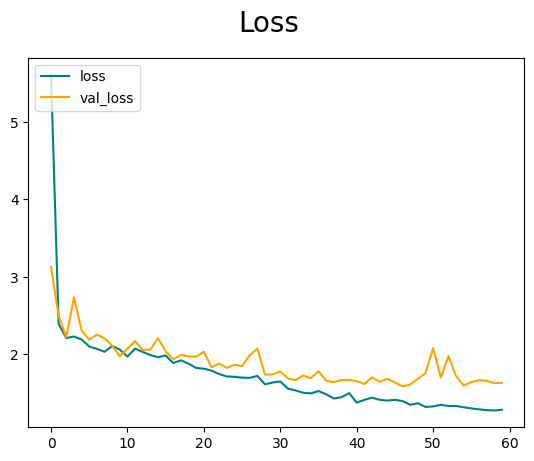

In [14]:
fig=plt.figure()
plt.plot(hist.history['loss'],color='teal',label='loss')
plt.plot(hist.history['val_loss'],color='orange',label='val_loss')
fig.suptitle('Loss',fontsize=20)
plt.legend(loc='upper left')
plt.show()

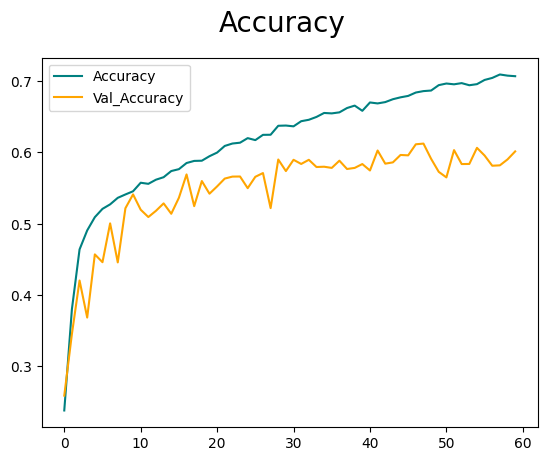

In [15]:
fig=plt.figure()
plt.plot(hist.history['accuracy'],color='teal',label='Accuracy')
plt.plot(hist.history['val_accuracy'],color='orange',label='Val_Accuracy')
fig.suptitle('Accuracy',fontsize=20)
plt.legend(loc='upper left')
plt.show()

In [16]:
# Saving the Model
model.save('model1.h5')

In [ ]:
from keras.models import load_model
model=load_model('model.h5')

In [ ]:
# import cv2
# # Load the image
# img = cv2.imread("D:\\Machine Learning\\Projects\\Image Classifier\\Testing\\1.jpg")
# # Load the cascade classifier for face detection
# face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# # Detect faces in the image
# faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5)

# # Crop the faces and display them
# for (x, y, w, h) in faces:
#     # Crop the image to the specified coordinates
#     face = img[y:y+h, x:x+w]

#     # Display the cropped face
#     cv2.imwrite("D:\\Machine Learning\\Projects\\Image Classifier\\Testing\\zoomed.jpg", face)
#     # cv2.imshow('Face', face)
# resize=tf.image.resize(face,(54,54))
# plt.imshow(resize.numpy().astype(int))
# plt.show()

import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread("..\\Testing\\10.jpg")
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
# Load the cascade classifier for face detection
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Detect faces in the image
faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5)

# Process each detected face
for (x, y, w, h) in faces:
    # Crop the image to the specified coordinates
    face = img[y:y+h, x:x+w]

    # Convert the face to grayscale
    gray_face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)

    # Resize the grayscale face to 54x54 pixels
    resized_gray_face = cv2.resize(gray_face, (54, 54))

    # Display the resized grayscale face
    # plt.imshow(resized_gray_face, cmap='gray')
    plt.show()


In [ ]:
yhat=model.predict(np.expand_dims(resized_gray_face/255,0))
output=(np.argmax(yhat))
if(output==0):
    print('Angry Face Detected')
elif(output==1):
    print('Disgusted Face Detected')
elif(output==2):
    print('Feared Face Detected')
elif(output==3):
    print('Happy Face Detected')
elif(output==4):
    print('Neutral Face Detected')
elif(output==5):
    print('Sad Face Detected')
elif(output==6):
    print('Surprised Face Detected')

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']